# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set(style="whitegrid")
plt.style.use('seaborn-notebook')

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
## Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';', low_memory=False)

## Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';', low_memory=False)

In [3]:
## shape of data frames
azdias.shape, feat_info.shape

((891221, 85), (85, 4))

In [4]:
## head of azdias
azdias.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [5]:
## head of feat_info
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
## nullity check on feat_info
feat_info.isnull().sum()

attribute             0
information_level     0
type                  0
missing_or_unknown    0
dtype: int64

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
## Identify missing or unknown data values and convert them to NaNs.
## check first if the order is same
feat_info.iloc[:, 0].values == azdias.columns.values 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [8]:
## index of attributes that missing label is not integer (Reference 'Data_Dictionary.md')
no_int = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']

for i, column in enumerate(azdias.columns):
    ## label of missing values for the corresponding attribute
    labels = feat_info['missing_or_unknown'].iloc[i]
    missings = list()
    if column in no_int:
        missings = labels.strip('[]').split(',')
    else:
        missings = ast.literal_eval(labels)
    
    ## substitute missing value labels to np.NaN
    for label in missings:
        azdias[column].replace(label, np.NaN, inplace=True)

In [9]:
azdias.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
## nullity check (proportion of null values)
temp = azdias.isnull().sum() / len(azdias)
## only features with null values
print("There are {} features out of {} with missing values".format(len(temp[temp != 0.0]), azdias.shape[1]))

There are 61 features out of 85 with missing values


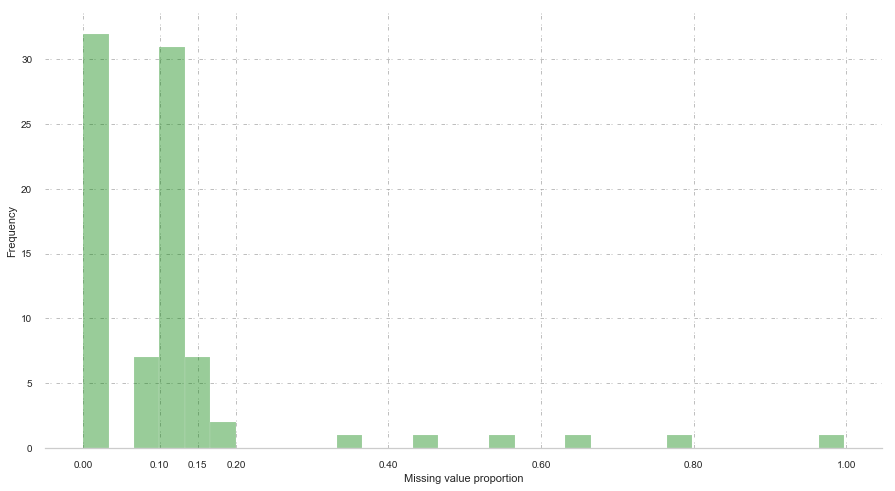

In [11]:
ax = temp.plot(kind='hist', bins=30, color='green', alpha=0.4, figsize=(15, 8))
sns.despine(left=True, top=True, right=True)
ax.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.5)
ax.set_xticks([0.0, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1.0]);
ax.set_xlabel('Missing value proportion');

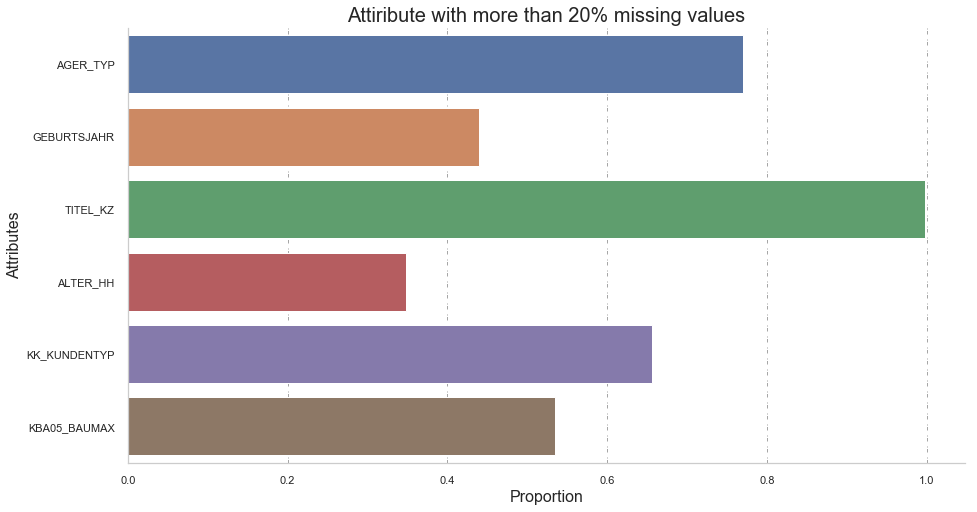

In [12]:
## Investigate patterns in the amount of missing data in each column.
## Vizualize attriutes that have more than 20% of missing values and I will remove these features
sns.set(style='whitegrid')
fig = plt.figure(figsize=(15, 8))
ax = sns.barplot(x=temp[temp > .20].values, y=temp[temp > .20].index)
ax.set_title("Attiribute with more than 20% missing values", fontsize=20)
ax.set_xlabel("Proportion", fontsize=16)
ax.set_ylabel("Attributes", fontsize=16)
ax.xaxis.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.7)
sns.despine(top=True, right=True)

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_cols = temp[temp > .20].index.values
azdias = azdias.drop(columns=drop_cols)
feat_info = feat_info.drop(feat_info[feat_info['attribute'].isin(drop_cols)].index)

## check if succeded
azdias.shape, feat_info.shape

((891221, 79), (79, 4))

In [14]:
temp = azdias.isnull().sum()
no_missings = temp[temp==0]
yes_missings = temp[temp>0]
print("There are {} features with missing values and {} features without missing values.".format(len(yes_missings), len(no_missings)))
print()
print("<Features with missing values>")
print(yes_missings.index.values)
print()
print("<Features without missing values>")
print(no_missings.index.values)

There are 55 features with missing values and 24 features without missing values.

<Features with missing values>
['ALTERSKATEGORIE_GROB' 'CJT_GESAMTTYP' 'GFK_URLAUBERTYP' 'HEALTH_TYP'
 'LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'LP_FAMILIE_FEIN'
 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN' 'LP_STATUS_GROB' 'NATIONALITAET_KZ'
 'PRAEGENDE_JUGENDJAHRE' 'RETOURTYP_BK_S' 'SHOPPER_TYP' 'SOHO_KZ'
 'VERS_TYP' 'ANZ_PERSONEN' 'ANZ_TITEL' 'HH_EINKOMMEN_SCORE'
 'W_KEIT_KIND_HH' 'WOHNDAUER_2008' 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL'
 'GEBAEUDETYP' 'KONSUMNAEHE' 'MIN_GEBAEUDEJAHR' 'OST_WEST_KZ' 'WOHNLAGE'
 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015' 'CAMEO_INTL_2015' 'KBA05_ANTG1'
 'KBA05_ANTG2' 'KBA05_ANTG3' 'KBA05_ANTG4' 'KBA05_GBZ' 'BALLRAUM'
 'EWDICHTE' 'INNENSTADT' 'GEBAEUDETYP_RASTER' 'KKK' 'MOBI_REGIO'
 'ONLINE_AFFINITAET' 'REGIOTYP' 'KBA13_ANZAHL_PKW' 'PLZ8_ANTG1'
 'PLZ8_ANTG2' 'PLZ8_ANTG3' 'PLZ8_ANTG4' 'PLZ8_BAUMAX' 'PLZ8_HHZ'
 'PLZ8_GBZ' 'ARBEIT' 'ORTSGR_KLS9' 'RELAT_AB']

<Features without missing values>

In [15]:
## to group features by same missing count
from collections import defaultdict
checker = defaultdict(list)
for i in range(len(yes_missings)):
    checker[yes_missings.iloc[i]].append(yes_missings.index[i])
    
checker = dict(checker)

## print out
for key in sorted(checker.keys(), reverse=True):
    print('missings: {:>6d}, features: {}'.format(key, checker[key]))

missings: 158064, features: ['KKK', 'REGIOTYP']
missings: 147988, features: ['W_KEIT_KIND_HH']
missings: 133324, features: ['KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO']
missings: 116515, features: ['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ']
missings: 111196, features: ['HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP']
missings: 108315, features: ['NATIONALITAET_KZ']
missings: 108164, features: ['PRAEGENDE_JUGENDJAHRE']
missings: 105800, features: ['KBA13_ANZAHL_PKW']
missings:  99611, features: ['ANZ_HAUSHALTE_AKTIV']
missings:  99352, features: ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']
missings:  97632, features: ['LP_LEBENSPHASE_FEIN']
missings:  97375, features: ['ARBEIT', 'RELAT_AB']
missings:  97274, features: ['ORTSGR_KLS9']
missings:  97008, features: ['ANZ_HH_TITEL']
missings:  94572, features: ['LP_LEBENSPHASE_GROB']
missings:  93740, features: ['BALLRAUM', 'EWDICHTE', 'INNENSTA

#### Discussion 1.1.2: Assess Missing Data in Each Column

There are 61 features out of 85 with missing values which means majory of features contain at least one missing values. As visualized with histogram, most missing value proportions reside within 20%; therefore I define outliers as features with more than 20% missing values and removed those 6 columns. 

When studied which features have missing values or not, it turned out personality features, financial features, and gender feature do not contain missing values. 

There are 24 unique missing value counts and all 55 missing value features fall into one of those groups.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

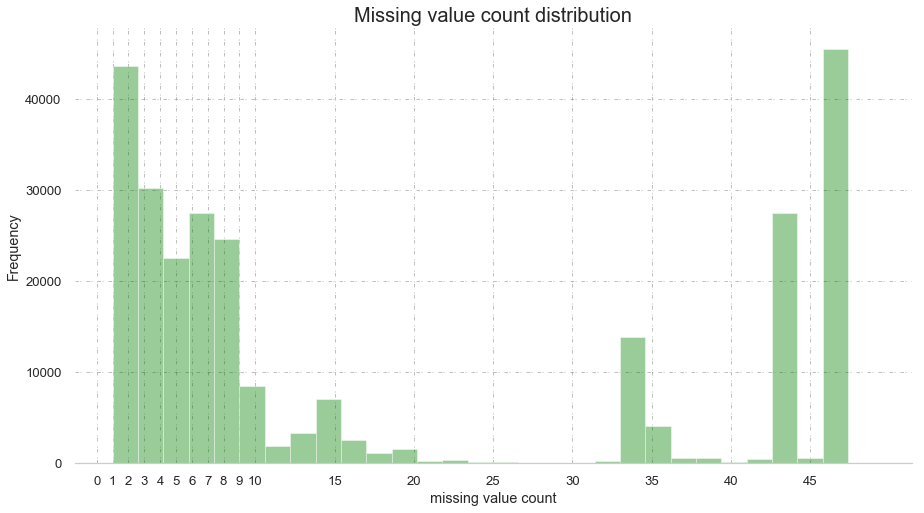

In [16]:
## Write code to divide the data into two subsets based on the number of missing
## values in each row.
missing_rows = azdias[azdias.isnull().any(axis=1)]
count = missing_rows.isnull().sum(axis=1)

sns.set(style='whitegrid', font_scale=1.2)
ax = count.plot(kind='hist', bins=30, color='green', alpha=0.4, figsize=(15, 8))
sns.despine(left=True, top=True, right=True)
ax.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.5)
ax.set_xlabel('missing value count')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45])
ax.set_title('Missing value count distribution', fontsize=20);

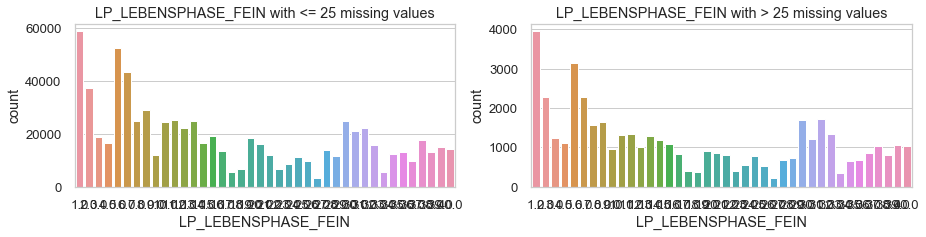

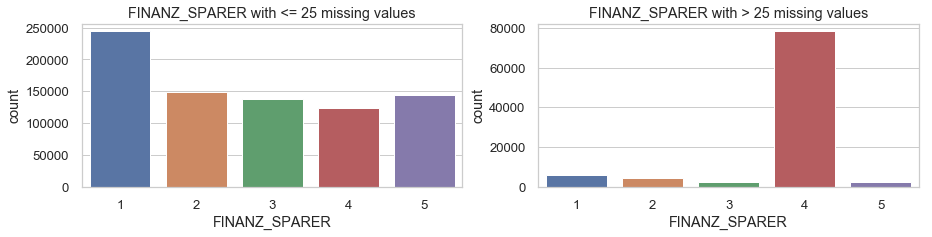

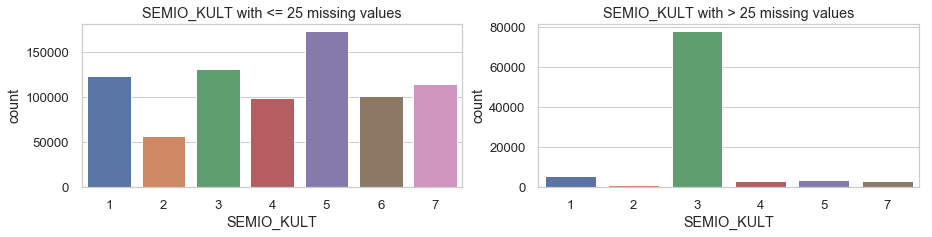

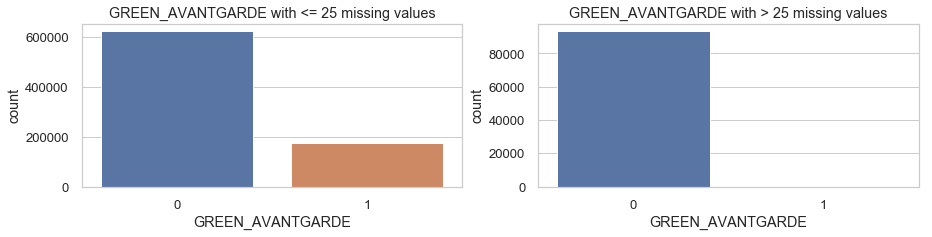

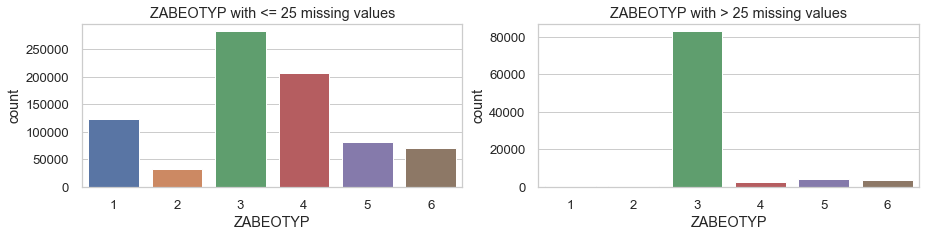

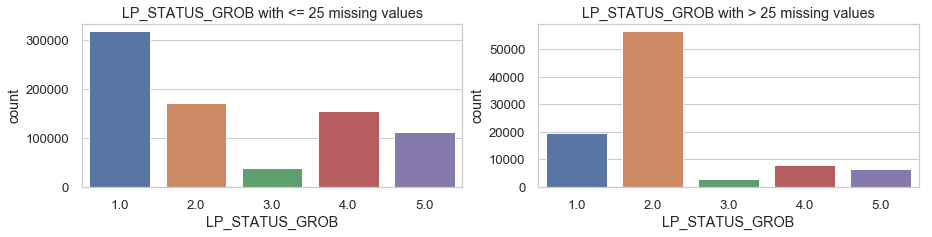

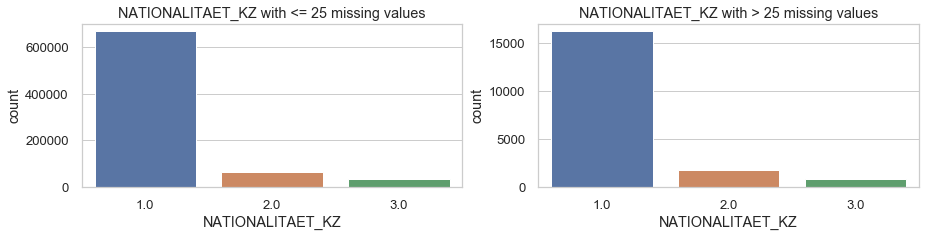

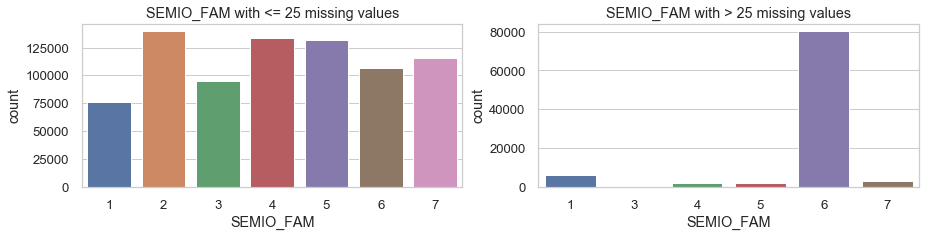

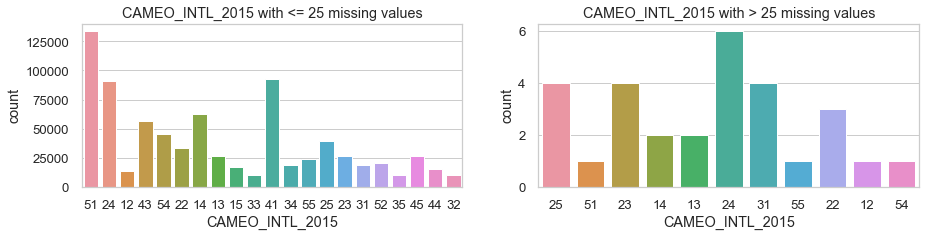

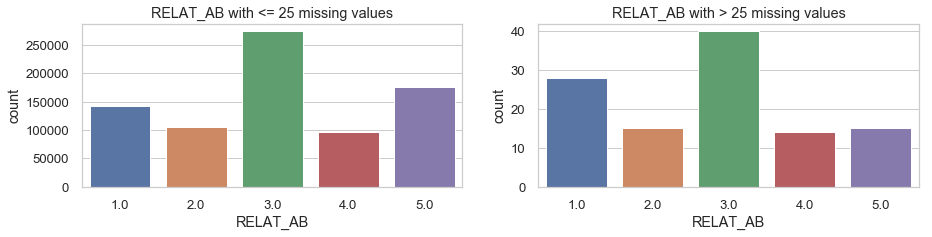

In [20]:
## Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.
sns.set(style='whitegrid', font_scale=1.2)

## helpfer function
def dist_plots(col_name, df1, df2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    sns.countplot(x=col_name, data=df1, ax=axs[0])
    axs[0].set_title(col_name+' with <= 25 missing values')
    sns.countplot(x=col_name, data=df2, ax=axs[1])
    axs[1].set_title(col_name+' with > 25 missing values')
    
## add helper column
azdias['null_count'] = 0
azdias.loc[count.index, 'null_count'] = count

## split data into to subset at cutoff 25
azdias_1 = azdias[azdias['null_count'] <= 25].copy()
outliers = azdias[azdias['null_count'] > 25].copy()

## drop helpfer column
azdias = azdias.drop(columns=['null_count'])
azdias_1 = azdias_1.drop(columns=['null_count'])
outliers = outliers.drop(columns=['null_count'])

col_ind = np.random.randint(0, azdias.columns.shape[0], 10)

for idx in col_ind:
    dist_plots(azdias.columns[idx], azdias_1, outliers)

In [21]:
azdias_1.shape, outliers.shape

((797961, 79), (93260, 79))

In [22]:
## update dataframe to no or few missing value dataframe
df = azdias_1 

In [23]:
temp = df.isnull().sum()
## check maximum proportion of missing value by features
(temp[temp>0] / len(df)).max()

0.08122577419197179

maximum missing value proportion is ~7%. let us remove all missing value rows.

In [24]:
## count rows that has at least one missing value
row_count = df[df.isnull().any(axis=1)].shape[0]
row_count

174752

#### Discussion 1.1.3: Assess Missing Data in Each Row

Missing value count distribution shows that we can split data at any value between 8 and 30. I chose 25 as the value and when we see above arbitrarily chosen columns distributions of two sub data. We do see some distinction between them. I use no or few missing value data from now on and it takes up ~87% of the original data. Those data points with more than 25 missing values are treated as outliers and will be regarded as cluster '-1'.

Also, I hoped that the rest data shares missing vlaues in the same rows as much as possible and, however, it turned out missing values are spread out throughout the rows in general. Maximum missing value proportion by features was ~ 6.96%. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
# How many features are there of each data type?
feat_info.iloc[:, 2].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [26]:
## For convenience of processing, let us split data by dtype
ordinals = df.columns[df.columns.isin(feat_info[feat_info['type'] == 'ordinal']['attribute'].values)]
categoricals = df.columns[df.columns.isin(feat_info[feat_info['type'] == 'categorical']['attribute'].values)]
mixeds = df.columns[df.columns.isin(feat_info[feat_info['type'] == 'mixed']['attribute'].values)]
numerics = df.columns[df.columns.isin(feat_info[feat_info['type'] == 'numeric']['attribute'].values)]
intervals = df.columns[df.columns.isin(feat_info[feat_info['type'] == 'intervals']['attribute'].values)]

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
temp = df[categoricals].nunique()
temp

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [28]:
print("Unique values in ")
for cat in categoricals:
    print("{:>17s}: {}".format(cat, df[cat].unique()))

Unique values in 
        ANREDE_KZ: [2 1]
    CJT_GESAMTTYP: [ 5.  3.  2.  4.  1.  6. nan]
        FINANZTYP: [1 6 5 2 4 3]
  GFK_URLAUBERTYP: [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]
 GREEN_AVANTGARDE: [0 1]
  LP_FAMILIE_FEIN: [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
  LP_FAMILIE_GROB: [ 3.  1. nan  5.  2.  4.]
   LP_STATUS_FEIN: [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
   LP_STATUS_GROB: [ 1.  2.  4.  5.  3. nan]
 NATIONALITAET_KZ: [ 1.  3.  2. nan]
      SHOPPER_TYP: [ 3.  2.  1.  0. nan]
          SOHO_KZ: [1. 0.]
         VERS_TYP: [ 2.  1. nan]
         ZABEOTYP: [5 3 4 1 6 2]
      GEBAEUDETYP: [8. 1. 3. 2. 6. 4. 5.]
      OST_WEST_KZ: ['W' 'O']
  CAMEO_DEUG_2015: ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
   CAMEO_DEU_2015: ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


It seems wee need to special-treat OST_WEST_KZ; that is, convert it to 0, 1

In [29]:
# ## remove categorical features that have at least 10 unique values
# drop_cats = temp[temp >= 10].index.values
# print(drop_cats)

# df = df.drop(columns=drop_cats)
# categoricals = categoricals.drop(drop_cats)
# feat_info = feat_info.drop(feat_info[feat_info['attribute'].isin(drop_cats)].index)


# ## check if succeded
# df.shape, feat_info.shape

In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.
## transform OST_WEST_KZ
df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'O': 0 , 'W': 1}) 

## get dummy variables for categorical data frame
cat_df = pd.get_dummies(df[categoricals].astype('category'))

# drop original categorical features
df = df.drop(columns=categoricals)

In [31]:
cat_df.shape

(797961, 138)

#### Discussion 1.2.1: Re-Encode Categorical Features

There are 18 categorical features and among binary categoricals, OST_WEST_KZ was a special case because even though it has only two labels it was recorded in letters not in 0 and 1 which can cause redundant dummy features when converting categoricals to numerical values (dummy variables). Using pandas' get_dummies function I ended up with 138 categorical columns. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [32]:
## Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
df['PRAEGENDE_JUGENDJAHRE'].value_counts().sort_index()

1.0      20678
2.0       7479
3.0      53841
4.0      20451
5.0      84687
6.0      25652
7.0       4010
8.0     141612
9.0      33570
10.0     85800
11.0     35751
12.0     24446
13.0      5764
14.0    182968
15.0     42543
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [33]:
feat_info[feat_info.iloc[:, 2]=='mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [34]:
## mapping dictionary for new variables
gen_map = {
    1: 1, 2: 1, # 40s
    3: 2, 4: 2, # 50s
    5: 3, 6: 3, 7: 3, # 60s
    8: 4, 9: 4, # 70s
    10: 5, 11: 5, 12: 5, 13: 5, # 80s
    14: 6, 15: 6  # 90s
}

mov_map = {
    1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1, # Mainstream
    2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2 # Avantgarde
}

## data frame for mixed type
mix_df = pd.DataFrame()

## add two ariables: generation & movement
mix_df['generation'] = df['PRAEGENDE_JUGENDJAHRE'].map(gen_map)
mix_df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(mov_map)

## drop 'PRAEGENDE_JUGENDJAHRE'
df = df.drop(columns=['PRAEGENDE_JUGENDJAHRE'])

In [35]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
df['CAMEO_INTL_2015'].value_counts().sort_index()

12     13248
13     26334
14     62882
15     16974
22     33152
23     26746
24     91152
25     39624
31     19020
32     10354
33      9935
34     18524
35     10356
41     92336
43     56672
44     14820
45     26132
51    133693
52     20542
54     45390
55     23954
Name: CAMEO_INTL_2015, dtype: int64

In [36]:
## mapping dictionary for new variables
wealth_map = {
    '11': 1, '12': 1, '13': 1, '14': 1, '15': 1, # Wealthy Households
    '21': 2, '22': 2, '23': 2, '24': 2, '25': 2, # Prosperous Households
    '31': 3, '32': 3, '33': 3, '34': 3, '35': 3, # Comfortable Households
    '41': 4, '42': 4, '43': 4, '44': 4, '45': 4, # Less Affluent Households
    '51': 5, '52': 5, '53': 5, '54': 5, '55': 5  # Poorer Households
}

life_stage_map = {
    '11': 1, '21': 1, '31': 1, '41': 1, '51': 1, # Pre-Family Couples & Singles
    '12': 2, '22': 2, '32': 2, '42': 2, '52': 2, # Young Couples With Children
    '13': 3, '23': 3, '33': 3, '43': 3, '53': 3, # Families With School Age Children
    '14': 4, '24': 4, '34': 4, '44': 4, '54': 4, # Older Families &  Mature Couples
    '15': 5, '25': 5, '35': 5, '45': 5, '55': 5  # Elders In Retirement
}

## add two ariables: generation & movement
mix_df['wealth'] = df['CAMEO_INTL_2015'].map(wealth_map)
mix_df['life_stage'] = df['CAMEO_INTL_2015'].map(life_stage_map)

## drop 'CAMEO_INTL_2015'
df = df.drop(columns=['CAMEO_INTL_2015'])

In [37]:
## 'generation' &'movement' and 'wealth' & 'life_stage' are categorical values
## therefore, let us convert them to category

## update to dummy tables for mixed type variables
mix_df = pd.get_dummies(mix_df[['generation', 'movement', 'wealth', 'life_stage']].astype('category'))

In [38]:
mix_df.shape

(797961, 18)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Based on 'Data_Dictionary.md' I divide two variables 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' into two seperate sub-varaibles that each hold one information. After merging dummy tables for new variables, I deleted original two variables because their informational is transfered to newly added variables derived from them. Now I have 18 variables in mix_df.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [39]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
## drop features
df = df.drop(columns=['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'])

LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB have similar information to those from PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015; therefore, I remove them. Even though WOHNLAGE contains two information, there is no clear cut because the information of whether neighborhood is rural or not seems just added to neighborhood quality information. Therefore I remove this feature as well. Finally, PLZ8_BAUMAX is formatted similar to WOHNLAGE. Therefore, I remove this feature. 

In [40]:
## recall ordinals, categoricals, mixeds, numerics, intervals(empty)
ord_df = df[ordinals].copy()
num_df = df[numerics].copy()

## combine all dtype dataframes into one
df = pd.concat([cat_df, mix_df, ord_df, num_df], axis=1)

df.shape

(797961, 211)

In [41]:
temp = df.isnull().sum()
temp[temp>0]

ALTERSKATEGORIE_GROB     2801
HEALTH_TYP              36680
RETOURTYP_BK_S           4713
W_KEIT_KIND_HH          59243
KONSUMNAEHE                70
KBA05_ANTG1             40064
KBA05_ANTG2             40064
KBA05_ANTG3             40064
KBA05_ANTG4             40064
KBA05_GBZ               40064
BALLRAUM                  592
EWDICHTE                  592
INNENSTADT                592
GEBAEUDETYP_RASTER          7
KKK                     64815
MOBI_REGIO              40064
ONLINE_AFFINITAET        4713
REGIOTYP                64815
PLZ8_ANTG1              23255
PLZ8_ANTG2              23255
PLZ8_ANTG3              23255
PLZ8_ANTG4              23255
PLZ8_HHZ                23255
PLZ8_GBZ                23255
ARBEIT                   4227
ORTSGR_KLS9              4126
RELAT_AB                 4227
ANZ_HAUSHALTE_AKTIV      6426
ANZ_HH_TITEL             3823
KBA13_ANZAHL_PKW        12549
dtype: int64

In [42]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    ## index of attributes that missing label is not integer (Reference 'Data_Dictionary.md')
    no_int = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']

    for i, column in enumerate(df.columns):
        ## label of missing values for the corresponding attribute
        labels = feat_info['missing_or_unknown'].iloc[i]
        missings = list()
        if column in no_int:
            missings = labels.strip('[]').split(',')
        else:
            missings = ast.literal_eval(labels)

        ## substitute missing value labels to np.NaN
        for label in missings:
            df[column].replace(label, np.NaN, inplace=True)

    ## remove selected columns and rows, ...
#     temp = df.isnull().sum() / len(df)
#     drop_cols = temp[temp > .15].index.values
    drop_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(columns=drop_cols)
    feat_info = feat_info.drop(feat_info[feat_info['attribute'].isin(drop_cols)].index)
    
    ## add helper column
    missing_rows = df[df.isnull().any(axis=1)]
    count = missing_rows.isnull().sum(axis=1)
    df['null_count'] = 0
    df.loc[count.index, 'null_count'] = count
    
    ## split data into to subset at cutoff 25
    outliers = df[df['null_count'] > 25]
    df = df[df['null_count'] <= 25]
    

    ## drop helpfer column
    df = df.drop(columns=['null_count'])
    outliers = outliers.drop(columns=['null_count'])
    
    # select, re-encode, and engineer column values.
    ## For convenience of processing, let us split data by dtype
    ordinals = df.columns[df.columns.isin(feat_info[feat_info['type'] == 'ordinal']['attribute'].values)]
    categoricals = df.columns[df.columns.isin(feat_info[feat_info['type'] == 'categorical']['attribute'].values)]
    mixeds = df.columns[df.columns.isin(feat_info[feat_info['type'] == 'mixed']['attribute'].values)]
    numerics = df.columns[df.columns.isin(feat_info[feat_info['type'] == 'numeric']['attribute'].values)]
    intervals = df.columns[df.columns.isin(feat_info[feat_info['type'] == 'intervals']['attribute'].values)]
    
    ## transform OST_WEST_KZ
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'O': 0 , 'W': 1}) 
    
    ## get dummy variables for categorical data frame
    cat_df = pd.get_dummies(df[categoricals].astype('category'))
    ## drop original categorical features
    df = df.drop(columns=categoricals)
    
    ## investigate some 'mixed' type


    ## data frame for mixed type
    mix_df = pd.DataFrame()

    ## add two ariables: generation & movement
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
            ## mapping dictionary for new variables
        gen_map = {
            1: 1, 2: 1, # 40s
            3: 2, 4: 2, # 50s
            5: 3, 6: 3, 7: 3, # 60s
            8: 4, 9: 4, # 70s
            10: 5, 11: 5, 12: 5, 13: 5, # 80s
            14: 6, 15: 6  # 90s
        }

        mov_map = {
            1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1, # Mainstream
            2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2 # Avantgarde
        }
        mix_df['generation'] = df['PRAEGENDE_JUGENDJAHRE'].map(gen_map)
        mix_df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(mov_map)

        ## drop 'PRAEGENDE_JUGENDJAHRE'
        df = df.drop(columns=['PRAEGENDE_JUGENDJAHRE'])
    
    if 'CAMEO_INTL_2015' in df.columns:
        ## mapping dictionary for new variables
        wealth_map = {
            '11': 1, '12': 1, '13': 1, '14': 1, '15': 1, # Wealthy Households
            '21': 2, '22': 2, '23': 2, '24': 2, '25': 2, # Prosperous Households
            '31': 3, '32': 3, '33': 3, '34': 3, '35': 3, # Comfortable Households
            '41': 4, '42': 4, '43': 4, '44': 4, '45': 4, # Less Affluent Households
            '51': 5, '52': 5, '53': 5, '54': 5, '55': 5  # Poorer Households
        }

        life_stage_map = {
            '11': 1, '21': 1, '31': 1, '41': 1, '51': 1, # Pre-Family Couples & Singles
            '12': 2, '22': 2, '32': 2, '42': 2, '52': 2, # Young Couples With Children
            '13': 3, '23': 3, '33': 3, '43': 3, '53': 3, # Families With School Age Children
            '14': 4, '24': 4, '34': 4, '44': 4, '54': 4, # Older Families &  Mature Couples
            '15': 5, '25': 5, '35': 5, '45': 5, '55': 5  # Elders In Retirement
        }

        ## add two ariables: generation & movement
        mix_df['wealth'] = df['CAMEO_INTL_2015'].map(wealth_map)
        mix_df['life_stage'] = df['CAMEO_INTL_2015'].map(life_stage_map)

        ## drop 'CAMEO_INTL_2015'
        df = df.drop(columns=['CAMEO_INTL_2015'])

        ## update to dummy tables for mixed type variables
        mix_df = pd.get_dummies(mix_df[['generation', 'movement', 'wealth', 'life_stage']].astype('category'))
    ## drop features
    for col in ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']:
        try:
            df = df.drop(columns=col)
        except:
            pass
    
    ## recall ordinals, categoricals, mixeds, numerics, intervals(empty)
    ord_df = df[ordinals].copy()
    num_df = df[numerics].copy()

    ## combine all dtype dataframes into one
    df = pd.concat([cat_df, mix_df, ord_df, num_df], axis=1)
    
    # Return the cleaned dataframe.
    return df, outliers
    

In [43]:
# ## Load in the general demographics data.
# azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';', low_memory=False)

# ## Load in the feature summary file.
# feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';', low_memory=False)

# ## clean using clean_data()
# df, outliers = clean_data(azdias, feat_info)

Missing value size is reduced by a lot.

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [44]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
temp = df.isnull().sum()
## names of columns that have missing value(s)
missings = temp[temp>0].index

In [45]:
missings

Index(['ALTERSKATEGORIE_GROB', 'HEALTH_TYP', 'RETOURTYP_BK_S',
       'W_KEIT_KIND_HH', 'KONSUMNAEHE', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS9', 'RELAT_AB', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'KBA13_ANZAHL_PKW'],
      dtype='object')

In [46]:
## check type of missing value columns
feat_info[feat_info['attribute'].isin(missings)][['attribute', 'type']]

,attribute,type
1,ALTERSKATEGORIE_GROB,ordinal
14,HEALTH_TYP,ordinal
23,RETOURTYP_BK_S,ordinal
48,W_KEIT_KIND_HH,ordinal
50,ANZ_HAUSHALTE_AKTIV,numeric
51,ANZ_HH_TITEL,numeric
53,KONSUMNAEHE,ordinal
60,KBA05_ANTG1,ordinal
61,KBA05_ANTG2,ordinal
62,KBA05_ANTG3,ordinal


It all seems ordinal or numeric. I might need to approach differently by data types - might have to choose different measures among mean, median and mode when imputing missing values

In [47]:
missing_numerics = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KBA13_ANZAHL_PKW']
missing_ordinals = missings.drop(missing_numerics).tolist()

In [48]:
df[missing_numerics].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KBA13_ANZAHL_PKW
count,791535.000000,794138.000000,785412.000000
mean,8.355292,0.040649,619.701014
std,15.674245,0.324042,340.034826
min,1.000000,0.000000,0.000000
25%,2.000000,0.000000,384.000000
50%,4.000000,0.000000,549.000000
75%,10.000000,0.000000,778.000000
max,595.000000,23.000000,2300.000000


In [49]:
## including mode in statistics describe
mode = df[missing_ordinals].mode()
mode.index = ['mode']

df[missing_ordinals].describe().append(mode)

,ALTERSKATEGORIE_GROB,HEALTH_TYP,RETOURTYP_BK_S,W_KEIT_KIND_HH,KONSUMNAEHE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,...,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,795160.000000,761281.000000,793248.000000,738718.000000,797891.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,...,733146.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793734.000000,793835.000000,793734.000000
mean,2.795403,2.199036,3.443064,4.161779,3.023133,1.494277,1.265584,0.624525,0.305927,3.158580,...,4.472086,2.253330,2.801858,1.595426,0.699166,3.612821,3.381087,3.166730,5.293469,3.071077
std,1.018420,0.755168,1.454431,1.778812,1.550701,1.403961,1.245178,1.013443,0.638725,1.329537,...,1.836362,0.972008,0.920309,0.986736,0.727137,0.973967,1.111598,0.999059,2.303347,1.360533
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,3.000000,1.000000,2.000000,1.000000,0.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,3.000000,2.000000,4.000000,4.000000,3.000000,1.000000,1.000000,0.000000,0.000000,3.000000,...,5.000000,2.000000,3.000000,2.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,4.000000,3.000000,5.000000,6.000000,4.000000,3.000000,2.000000,1.000000,0.000000,4.000000,...,6.000000,3.000000,3.000000,2.000000,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,4.000000,3.000000,5.000000,6.000000,7.000000,4.000000,4.000000,3.000000,2.000000,5.000000,...,7.000000,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,5.000000
mode,3.000000,3.000000,5.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,6.000000,2.000000,3.000000,2.000000,0.000000,3.000000,3.000000,4.000000,5.000000,3.000000


In [50]:
## Apply sklearn imputer
## impute missing_numerics 
imp_numerics = SimpleImputer(missing_values=np.nan, strategy="mean")
missing_numerics_array = imp_numerics.fit_transform(df[missing_numerics])

## impute missing_ordinals
imp_ordinals = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
missing_ordinals_array = imp_ordinals.fit_transform(df[missing_ordinals])

In [51]:
df[missing_numerics] = missing_numerics_array
df[missing_ordinals] = missing_ordinals_array

In [52]:
temp = df.isnull().sum()
temp[temp>0]

Series([], dtype: int64)

No missing values any more. 

In [53]:
df_unscaled = df.copy()

In [54]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df.values)

### Discussion 2.1: Apply Feature Scaling

When checking features with missing values, there were mostly ordinal features and a few numeric features. Since ordinal features have its own order and labels are integer values, it is not sensible to substitute the means for missing values. Therefore, I chose the modes (most frequent labels) to represent missing values and as for numerical features, I substituted missing values with the means. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [55]:
def pca_plot(pca):
    length = len(pca.explained_variance_ratio_)
    component_num = range(1, length+1)
    values = pca.explained_variance_ratio_
    cumul = np.cumsum(values)

    sns.set(style='whitegrid', font_scale=1.1)
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    ax.bar(component_num, values, color = 'blue', alpha=0.25)
    plt.ylabel("Variance Explained (%)")
    plt.xlabel("Principal Component")
    ax.grid(color="blue", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.6)
    ax.xaxis.grid(False)

    ax2 = plt.twinx()
    ax2.plot(component_num, cumul, color='green')
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    ax2.grid(color="green", linestyle="dotted", alpha=0.7)

    sns.despine(top=True, right=True, left=True)

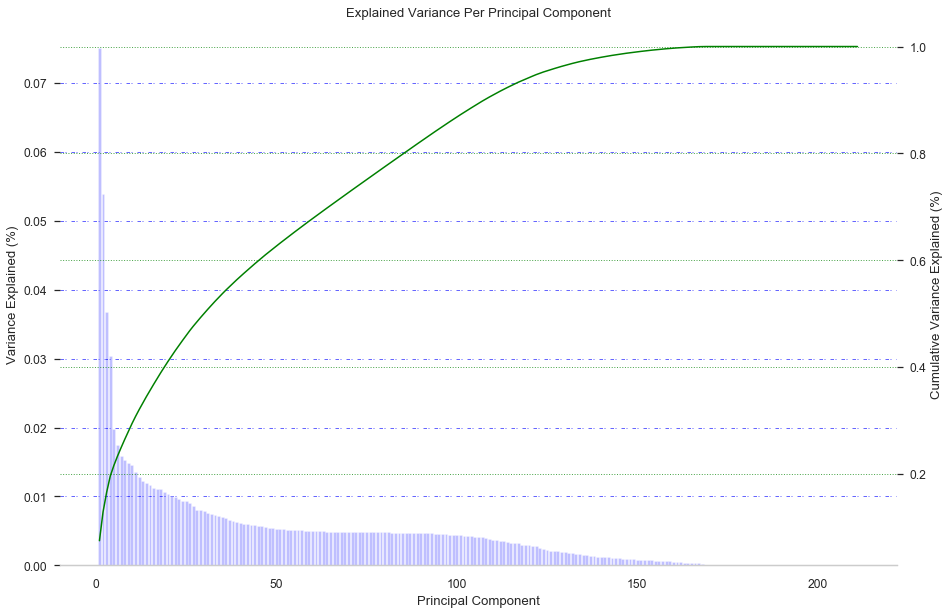

In [56]:
# Apply PCA to the data.
pca = PCA()
pca.fit(df.values)

pca_plot(pca)

In [57]:
## find indices of 95% variances
values = pca.explained_variance_ratio_
cumul = np.cumsum(values)

np.min(np.where(cumul>=0.95))

123

In [58]:
# Re-apply PCA to the data while selecting for number of components to retain.
## First 123 features take up about 95%, therefore, I will use 123 features
pca = PCA(123)
pca.fit(df.values)

# pca_plot(pca)

PCA(copy=True, iterated_power='auto', n_components=123, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Discussion 2.2: Perform Dimensionality Reduction

I decided to take features that explains 95% of the variance which are equivalent to 123 features. This decision is made because as you can see on the graph above from x=123, cumulated variance increases very slowly and 95% variance explains enough of the whole variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [59]:
## let us see how weights changed based on pca component
def pca_nth_feature_weights(df, pca, n_component=1):
    weight = pca.components_[n_component-1].flatten()
    weight_df = pd.DataFrame({'feature': df.columns.values, 'weight': weight, 'nth': n_component})
    return weight_df

def print_weights(df, pca, n_component=1):
    weight = pca.components_[n_component-1].flatten()
    weight_df = pd.DataFrame({'feature': df.columns.values, 'weight': weight})
    weight_df = weight_df.sort_values(by='weight', ascending=False).set_index('feature')
    print(weight_df)
    return weight_df

def max_min_feature(dff):
    dff = dff.sort_values(by='weight', ascending=False)
    max_feat = (dff['feature'].iloc[0], dff['weight'].iloc[0])
    min_feat = (dff['feature'].iloc[-1], dff['weight'].iloc[-1])
    return max_feat, min_feat

In [60]:
## To see printed version, please comment out the below. 
# print_weights(df, pca, n_component=1)

<1st component>
Largest weight :  0.1929 (LP_STATUS_GROB_1.0)
Smallest weight: -0.1878 (FINANZ_MINIMALIST)

<2nd component>
Largest weight :  0.2295 (ALTERSKATEGORIE_GROB)
Smallest weight: -0.2246 (FINANZ_SPARER)

<3rd component>
Largest weight :  0.3212 (ANREDE_KZ_1)
Smallest weight: -0.3212 (ANREDE_KZ_2)



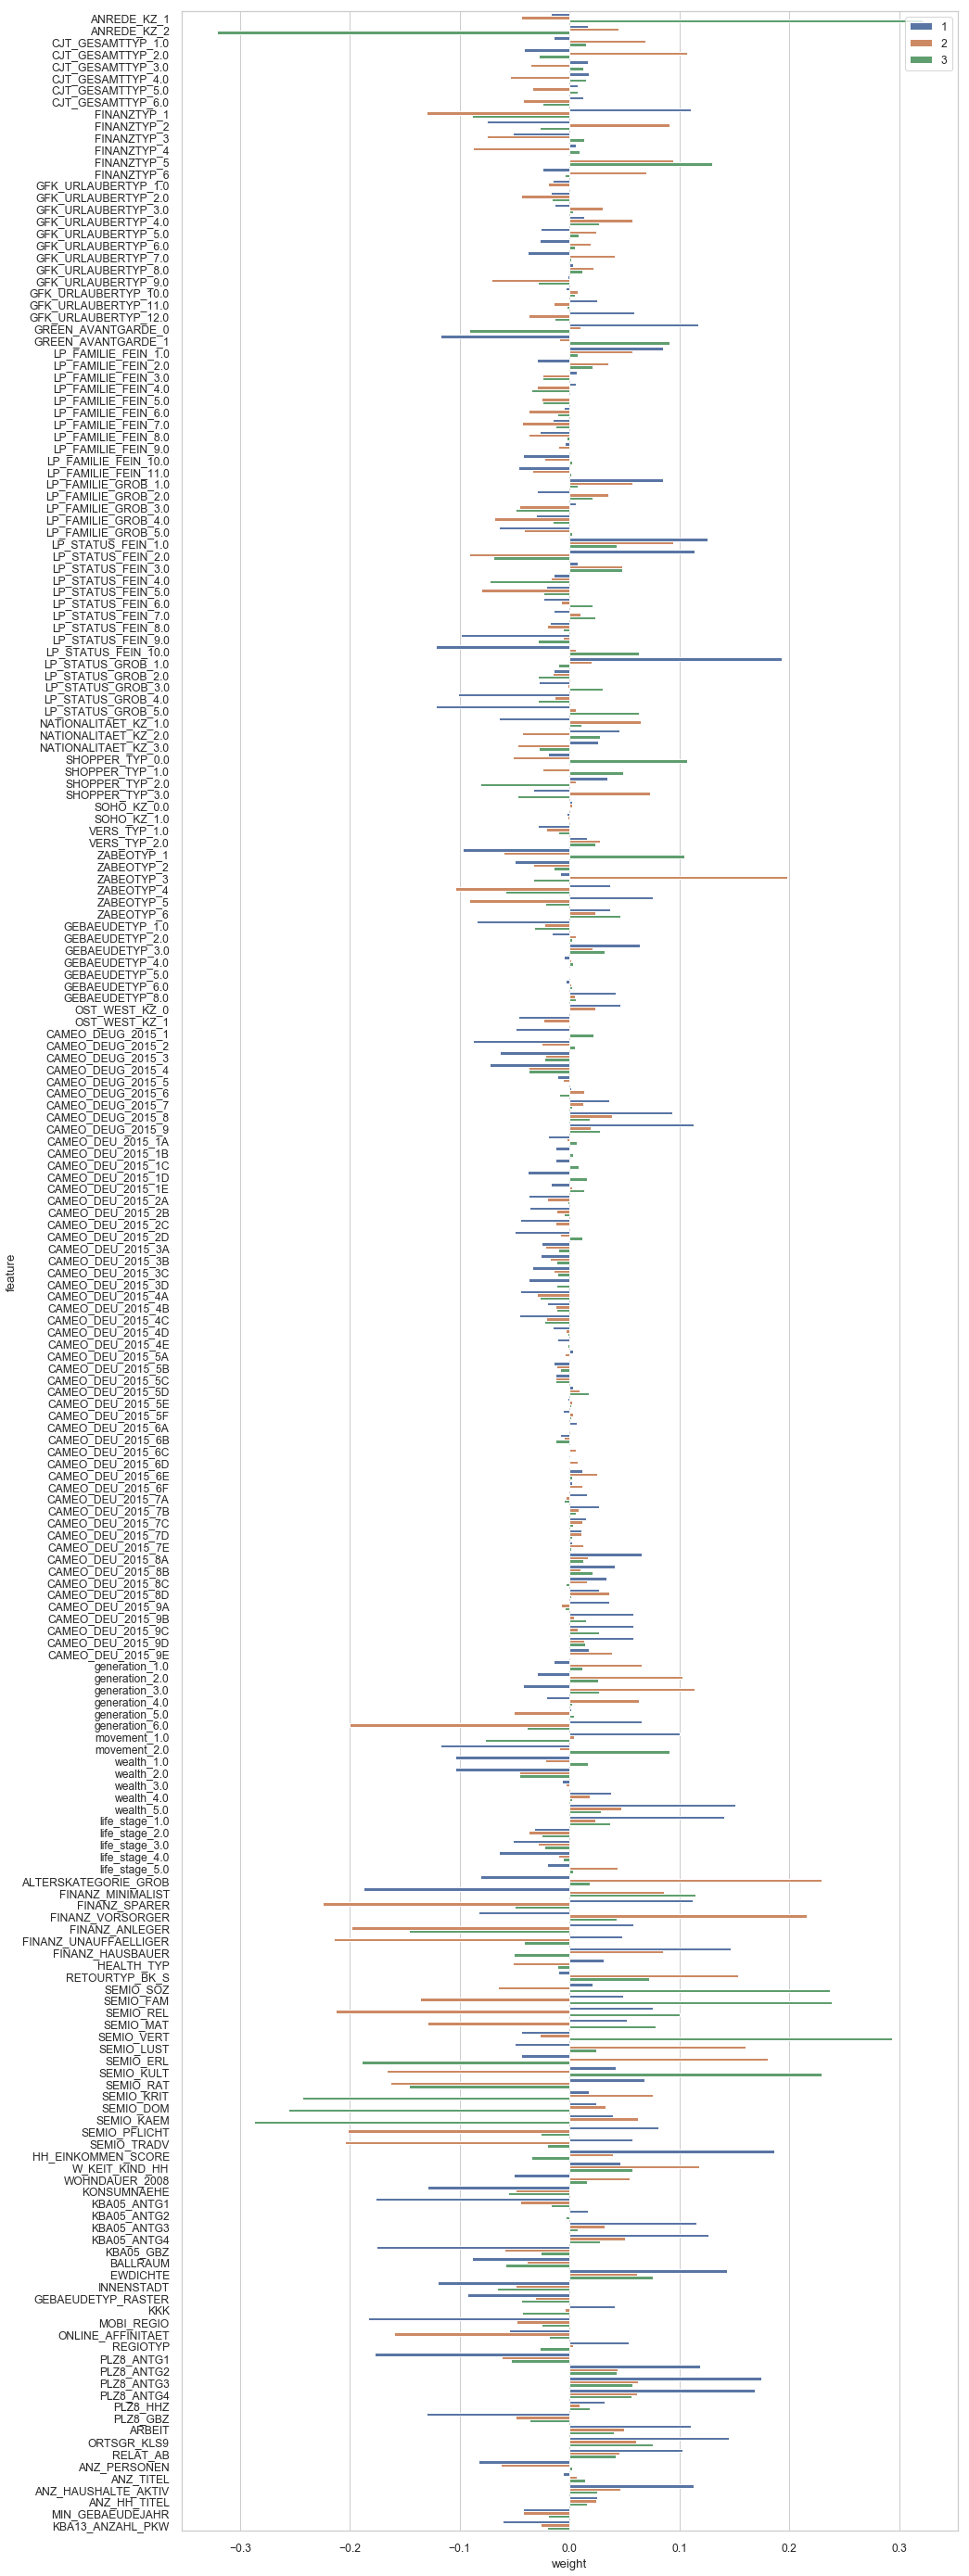

In [61]:
weight_df1 = pca_nth_feature_weights(df, pca, n_component=1)
weight_df2 = pca_nth_feature_weights(df, pca, n_component=2)
weight_df3 = pca_nth_feature_weights(df, pca, n_component=3)

## combine vertically
weight_df = pd.concat([weight_df1, weight_df2, weight_df3])

## print largest, smallest weight and feature for each coponent
max_feat, min_feat= max_min_feature(weight_df1)
print('<1st component>')
print('Largest weight : {:7.4f} ({})'.format(max_feat[1], max_feat[0]))
print('Smallest weight: {:7.4f} ({})'.format(min_feat[1], min_feat[0]))
print()
max_feat, min_feat= max_min_feature(weight_df2)
print('<2nd component>')
print('Largest weight : {:7.4f} ({})'.format(max_feat[1], max_feat[0]))
print('Smallest weight: {:7.4f} ({})'.format(min_feat[1], min_feat[0]))
print()
max_feat, min_feat= max_min_feature(weight_df3)
print('<3rd component>')
print('Largest weight : {:7.4f} ({})'.format(max_feat[1], max_feat[0]))
print('Smallest weight: {:7.4f} ({})'.format(min_feat[1], min_feat[0]))
print()

## visualize
plt.figure(figsize=(15, 50))
ax=sns.barplot(x='weight', y='feature', hue='nth', data=weight_df)
ax.legend(loc='upper right');

### Discussion 2.3: Interpret Principal Components

Results are as below:
> <1st component> <br>
  Largest weight :  0.1929 (LP_STATUS_GROB_1.0 - Social status) <br>
  Smallest weight: -0.1878 (FINANZ_MINIMALIST - Financial typology)

> <2nd component> <br>
  Largest weight :  0.2295 (ALTERSKATEGORIE_GROB - Estimated age) <br>
  Smallest weight: -0.2246 (SEMIO_REL - Personality typology)

> <3rd component> <br>
  Largest weight :  0.3212 (ANREDE_KZ_1 - Gender (male))<br>
  Smallest weight: -0.3212 (ANREDE_KZ_2- Gender (female))

- For the first principal component, these two features denote social status and financial typology respectively. 
- For the second component, largest and smallest weight features are about age and personality. 
- For the third component, largest and smallest weight features are about genders, specifically, male and female.
- Also, I plotted the weights by features of 1st, 2nd, and 3rd components above. As you can see, weights fluctuate a lot in the same feature and there seems no general order of weight particularly. That is, each pricinpal component has different order of weights.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [62]:
## Get reduced dataset by pca
df_pca = pca.transform(df)

df_pca.shape

(797961, 123)

In [63]:
# Over a number of different cluster counts...
avg_squared_dists = list()
# silhouette_avgs = list()
for n in range(2, 16):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=n, random_state=614).fit(df_pca)
    
    # compute the average within-cluster distances.
    avg_squared_dists.append(kmeans.inertia_ / n)
#     silhouette_avgs.append(silhouette_score(df_pca, kmeans.labels_))

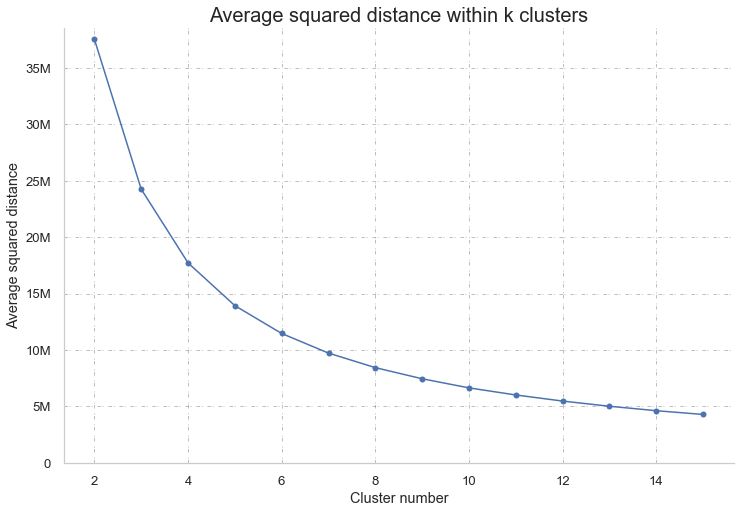

In [64]:
# Investigate the change in within-cluster distance across number of clusters.
sns.set(style='whitegrid', font_scale=1.2)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(range(2,16), avg_squared_dists, marker='o')
ax.set_ylim(0, max(avg_squared_dists)+2000000)
ax.set_yticklabels(['0', '5M', '10M', '15M', '20M', '25M', '30M', '35M'])
ax.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.5)
sns.despine(top=True, right=True)
plt.title("Average squared distance within k clusters", fontsize=20)
ax.set_ylabel("Average squared distance")
ax.set_xlabel("Cluster number");

It seems really hard to find the elbow point because there is not clear point. Let us check amount of change in value (gradients) instead to find k.

In [65]:
gradients = list()
for i in range(1, len(avg_squared_dists)):
    gradients.append(avg_squared_dists[i]-avg_squared_dists[i-1])

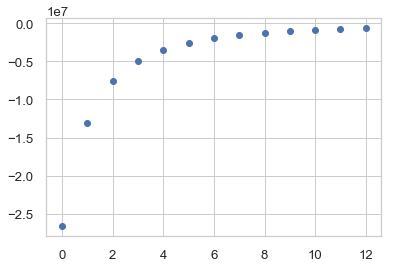

In [66]:
plt.scatter(range(len(gradients)), gradients);

It appears from 5th point, there is not much difference in values. Therefore, I will pick 7 as cluster number k. (remeber 5th point is equivalent to 5th slope in average squared distance graph)

In [67]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(7).fit(df_pca)
pred_azdias = kmeans.predict(df_pca)

### Discussion 3.1: Apply Clustering to General Population

Using the elbow method, I tried to find the elbow point (cluster number); however using average squared distance chart the point was not obvious. Therefore, I employed gradient to find the point where gradient starts to be steady, which was 5th point and it is equivalant to 5th slope in average squared distance chart. For this reason, I chose 7 as cluster number.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [68]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';', low_memory=False)
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';', low_memory=False)

In [69]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers, customers_outliers = clean_data(customers, feat_info)

In [70]:
## just in case missing columns exists due to no labels in certain variables, add with zero values
for value in df.columns[~df.columns.isin(customers.columns)].values:
    customers[value] = 0

In [71]:
customers.shape, df.shape

((141713, 211), (797961, 211))

In [72]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.
temp = customers.isnull().sum()
## names of columns that have missing value(s)
missings = temp[temp>0].index

In [73]:
missing_numerics = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KBA13_ANZAHL_PKW']
missing_ordinals = missings.drop(missing_numerics).tolist()
missing_ordinals.append('GEBAEUDETYP_RASTER')

In [74]:
## Apply sklearn imputer
## impute missing_numerics 
imp_numerics = SimpleImputer(missing_values=np.nan, strategy="mean")
missing_numerics_array = imp_numerics.fit_transform(customers[missing_numerics])
# missing_numerics_array = imp_numerics.transform(customers[missing_numerics])

## impute missing_ordinals
imp_ordinals = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
missing_ordinals_array = imp_ordinals.fit_transform(customers[missing_ordinals])
# missing_ordinals_array = imp_ordinals.transform(customers[missing_ordinals])

In [75]:
customers[missing_numerics] = missing_numerics_array
customers[missing_ordinals] = missing_ordinals_array

In [76]:
customer_unscaled = customers.copy()

In [77]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
customers[customers.columns] = scaler.fit_transform(customers.values)
# customers[customers.columns] = scaler.transform(customers.values)

In [78]:
customer_pca = pca.transform(customers)
## predict label
pred_customer = kmeans.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [79]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

## prepare proportion data frame
df_pred_azdias = pd.DataFrame({'cluster': pred_azdias, 'proportion': np.zeros_like(pred_azdias)})
df_pred_customer = pd.DataFrame({'cluster': pred_customer, 'proportion': np.zeros_like(pred_customer)})

df_prop_a = df_pred_azdias.groupby('cluster').count() / len(df_pred_azdias)
df_prop_c = df_pred_customer.groupby('cluster').count() / len(df_pred_customer)

df_prop_a['from'] = 'population'
df_prop_c['from'] = 'customer'

df_prop = pd.concat([df_prop_a, df_prop_c])
df_prop = df_prop.reset_index()

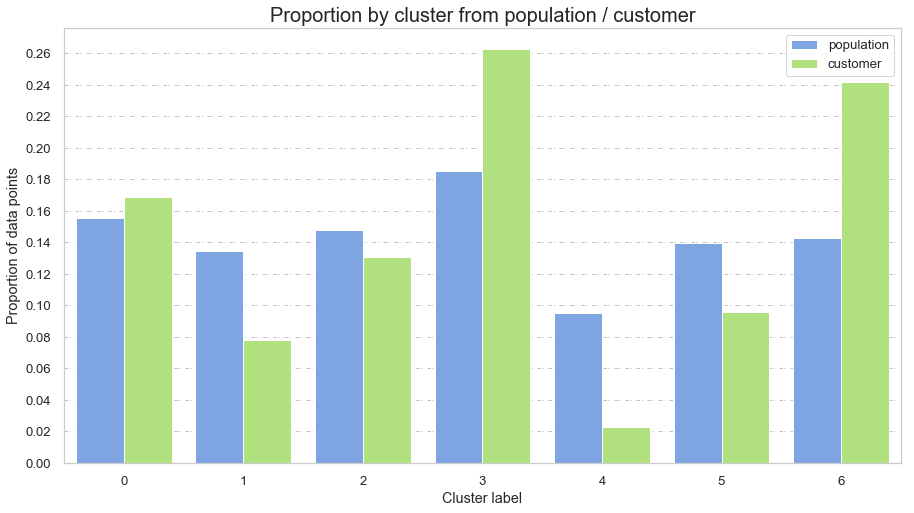

In [80]:
## vizualize proportion by 
plt.figure(figsize=(15, 8))
ax = sns.barplot(x='cluster', y = 'proportion', data=df_prop, hue='from', palette=['#6da0f2', '#b1f16d'])

ax.legend()
plt.title("Proportion by cluster from population / customer", fontsize=20)
plt.xlabel("Cluster label")
plt.ylabel("Proportion of data points")

ax.yaxis.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.5)
ax.set_yticks(np.linspace(0, 0.26, 14));

clusters that are overrepresented in the customer data: 0, 3, 6 <br>
clusters that are underrepresented in the customer data: 1, 2, 4, 5

In [82]:
# What kinds of people are part of a cluster that is overrepresented or underrepresented in the
# customer data compared to the general population?

over_idx = np.where((pred_azdias == 0) | (pred_azdias == 3) | (pred_azdias ==6))[0]
under_idx = np.where((pred_azdias ==1) | (pred_azdias == 2) | (pred_azdias ==4) | (pred_azdias == 5))[0]
 
over_df = df_unscaled.iloc[over_idx]
under_df =  df_unscaled.iloc[under_idx]

## recall 2.3
largest_weights = ['LP_STATUS_GROB_1.0', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ_1']
smallest_weights = ['FINANZ_MINIMALIST', 'SEMIO_REL', 'ANREDE_KZ_2']

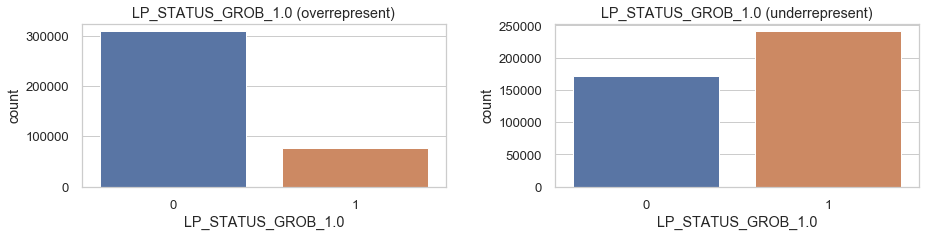

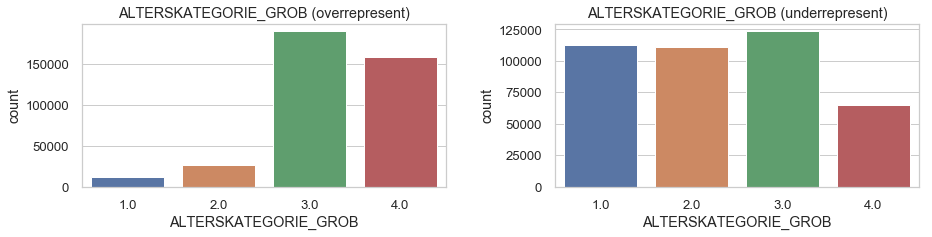

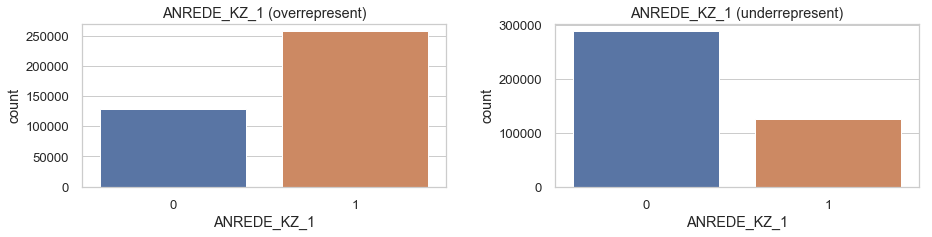

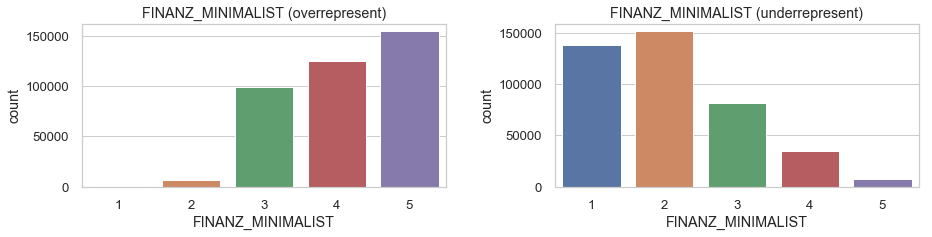

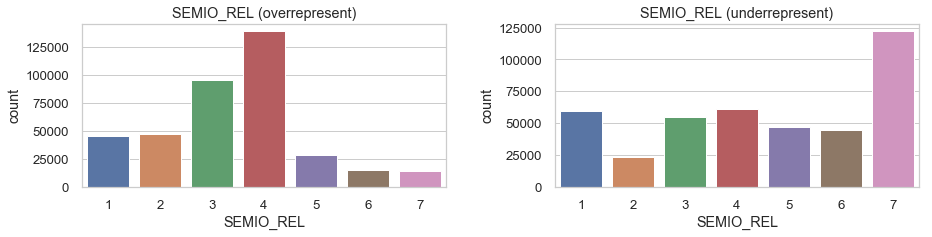

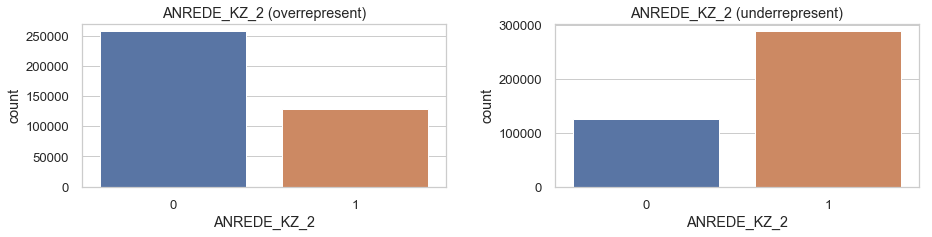

In [83]:
## helpfer function
def dist_plots_2(col_name, df1, df2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    sns.countplot(x=col_name, data=df1, ax=axs[0])
    axs[0].set_title(col_name+' (overrepresent)')
    sns.countplot(x=col_name, data=df2, ax=axs[1])
    axs[1].set_title(col_name+' (underrepresent)')
    plt.subplots_adjust(wspace=0.3)
    
## Visualize
for idx in range(3):
    dist_plots_2(largest_weights[idx], over_df, under_df)
    
for idx in range(3):
    dist_plots_2(smallest_weights[idx], over_df, under_df)

In [84]:
# Compare ouliers
print('Outlier by assessed missing data in each row (cluster -1)\n')
print('Population: {}'.format(len(outliers)))
print('Percentage for the total: {:.1f}%\n'.format(len(outliers) / len(df) *100.))
print('Customer: {}'.format(len(customers_outliers)))
print('Percentage for the total: {:.1f}%\n'.format(len(customers_outliers) / len(customers) * 100.))

Outlier by assessed missing data in each row (cluster -1)

Population: 93260
Percentage for the total: 11.7%

Customer: 49939
Percentage for the total: 35.2%



### Discussion 3.3: Compare Customer Data to Demographics Data

To compare what kind of people are overrepresent and underrerpresent in customer data, I split the data into 2 - overrepresent group and underrepresent group and I plotted 6 charts - 3 largest weight features in first 3 principal components and 3 smallest weight features. I describe the meaning in the same order I just mentioned. 

1. LP_STATUS_GROB_1.0: is from LP_STATUS_GROB which denotes person's social status. Especially 1 means that person is low-incom earner. Overrepresent members are much less likely in low-income status than underrepresent members. 

2. ALTERSKATEGORIE_GROB: shows estimated age. label 3 and 4 (age from 46) show little difference. However, underrepresent group has more younger people (under age 46) proportion-wise. 

3. ANREDE_KZ_1: means gender, especially male. Overrepresent group people are more likely males. 

4. FINANZ_MINIMALIST: is finfancial typology which is denotes person's financial capacity. The higher the label is, the smaller financial capacity is. Graphs show that overrepresent group are less financially capable than underrepresent group

5. SEMIO_REL: indicates the personality of 1 - 7 labels. 1 is 'highest affinity' and 7 is 'lowest affinity'. the result shows that overrepresent group person is more apt to show average affinity or higher affinity and on the contrary, underreperesent group shows more balanced proportions of personality. 

6.  ANREDE_KZ_2: means gender, especially female. Directly related to the discussion in third point. Underrepresent group people are more likely females.

Thus, we can describe sements of the population that are relatively popular with the mail-order company or unpopular, and company can craft a strategy to target unpopular group people. 

Finaly about outlier by assessed missing data in each row named cluster -1, percentage for population is 11.7%, on the other hand percentage for customer is 35.2%. So, when we use the trained model in real world, the model would have more outliers than it is trained to. 